In [36]:
import torchvision
import torch
import numpy as np
from torchvision import transforms
import os
os.chdir("../")
from src.core.models import resnet
from tqdm import tqdm

In [6]:
import torch.nn.functional as F

In [38]:
trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),]
)

imagenet_train  = torchvision.datasets.ImageNet('/data/opensets/imagenet-pytorch', 
                                                split='train',
                                                transform = trans)


data_loader = torch.utils.data.DataLoader(imagenet_train,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=0)

len(imagenet_train)

1281167

In [27]:
model = resnet.resnet50(pretrained=True)

In [37]:
label_saver = list()
feat_saver = list()

for imgs,labels in tqdm(data_loader):
    feat = model._forward_impl(imgs)
    feat = F.avg_pool2d(feat, 4).squeeze()
    
    label_saver += list(labels.cpu().numpy())
    feat_saver += list(feat.detach().cpu().numpy())

  0%|          | 6/40037 [00:06<12:15:59,  1.10s/it]


KeyboardInterrupt: 

In [48]:
feat_torch = torch.tensor(feat_saver)
label_torch = torch.tensor(label_saver)
save_dict = {'feat' : feat_torch, 'label_torch':label_torch}

o = torch.save(save_dict, '/data/private/Uncertainty-CAM/ckpt_feat/feats.pt')
print(o)

None


In [49]:
load_dict = torch.load('/data/private/Uncertainty-CAM/ckpt_feat/feats.pt')

In [41]:
feat_torch.shape

torch.Size([192, 2048])

In [29]:
len(feat_saver), len(label_saver)

(1344, 1344)

In [30]:
feat_saver[0].shape

(2048,)

In [32]:
from sklearn.manifold import TSNE

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne = TSNE(n_components=n_components,
            perplexity = 30)

tsne_projection = tsne.fit_transform(feat_saver)


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


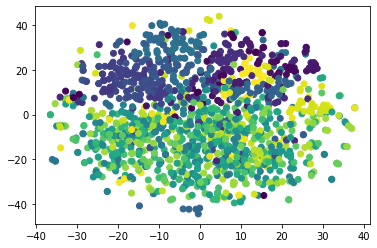

In [33]:
import matplotlib.pyplot as plt
plt.scatter(tsne_projection[:,0], tsne_projection[:,1],c=label_saver)

In [35]:
import torch.nn as nn

class GMM(nn.Module):
    def __init__(self, dim, k=5):
        super(GMM, self).__init__()
        self.k = k 
        self.dim = dim
        self.mu  = nn.Parameter(torch.randn(k, dim)/2.)
        self.cov = nn.Parameter(torch.ones(k, dim)*-3e-2)
        self.pi = nn.Parameter(torch.ones(k,)/self.k)
        
    def forward(self, x):
        # x [B x d]
        cat = D.Categorical(F.softmax(self.pi))
        comp = D.Independent(D.Normal(self.mu, self.cov.exp()), 1)
        mixture = D.MixtureSameFamily(cat, comp)
        
        log_liks = mixture.log_prob(x)
        return log_liks
    
    def sample(self, size=1000):
        with torch.no_grad():
            cat = D.Categorical(F.softmax(self.pi))
            comp = D.Independent(D.Normal(self.mu, self.cov.exp()), 1)
            mixture = D.MixtureSameFamily(cat, comp)
            sample = mixture.sample((size,))
        
        return sample

In [ ]:
import torch.optim as optim

gmm_grad = GMM(k=1000, dim=2048,)
optimizer = optim.SGD(gmm_grad.parameters(), lr=1e-1, weight_decay=0)

fig = plt.figure()
ax = fig.subplots()
camera = Camera(fig)
EPOCH = 5000
print_every = EPOCH/40
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCH)

for ep in range(EPOCH):
    optimizer.zero_grad()
    
    log_liks = gmm_grad(torch.tensor(x))
    loss = log_liks.mean()* -1 
    
    print(str(ep)+" "+str(log_liks.mean().detach().numpy()), end='\r')
        
    loss.backward(retain_graph=True)
    optimizer.step()
    
    scheduler.step()